In [102]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import time

In [103]:
def delta(v_t_fire):
    if v_t_fire == 1.:
        return 1
    else:
        return 0

def depressing_synapses_model(x_t, y_t, z_t, t_rec, t_in, U, dt, v_t_fire):    
    dx = z_t / t_rec - U * x_t * delta(v_t_fire) * (1/dt)
    dy = - y_t / t_in + U * x_t * delta(v_t_fire) * (1/dt)
    dz = - z_t / t_rec + y_t / t_in
    
    x_t_ = x_t + dx * dt
    y_t_ = y_t + dy * dt
    z_t_ = z_t + dz * dt
    return x_t_, y_t_, z_t_

def IF_neuron(v_t, t_mem, I_syn, I_b, dt, v_t_fire, current_time, i_th_neuron, refrac_flag, intT, theta_i):
    if refrac_flag[i_th_neuron, current_time] == 1:
        v_t_ = 13.5
    else:
        dv = (- v_t + I_syn + I_b) / t_mem
        v_t_ = v_t + dv * dt
        if v_t_ >= theta_i:
            for i in range(30):
                if current_time + i >= intT:
                    pass
                else:
                    refrac_flag[i_th_neuron, current_time + i] = 1
            v_t_ = 13.5
            v_t_fire[i_th_neuron, current_time + 1] = 1.
            #print("neuron fired !")
    
    return v_t_

def raster(event_times_list, **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

def dynamic_theta_i(t_th, S_i, theta_i_t, theta_i_0, v_t_fire, dt):
    dtheta_i = - (theta_i_t - theta_i_0) / t_th + S_i * delta(v_t_fire) * (1/dt)
    theta_t_ = theta_i_t + dtheta_i * dt
    return theta_t_

In [104]:
N = 40

J_ij = np.empty((0, N))
for i in range(int(N)):
    tmp = np.zeros((1,N))
    for j in range(N):
        if randint(10) % 10 == 1:
            tmp[0, j] = 15 * np.random.normal(1, 0.5, 1)
    J_ij = np.append(J_ij, tmp, axis = 0)
"""
for i in range(int(4*N/5)):
    tmp = np.zeros((1,N))
    for j in range(N):
        if randint(10) % 10 == 1:
            tmp[0, j] = 10 * np.random.normal(1, 0.5, 1)
    J_ij = np.append(J_ij, tmp, axis = 0)
"""

'\nfor i in range(int(4*N/5)):\n    tmp = np.zeros((1,N))\n    for j in range(N):\n        if randint(10) % 10 == 1:\n            tmp[0, j] = 10 * np.random.normal(1, 0.5, 1)\n    J_ij = np.append(J_ij, tmp, axis = 0)\n'

In [108]:
x = 0.5
y = 0.5
z = 1 - x - y

#mili second
t_in= 3
t_mem = 30
t_th = 100

U = np.zeros(N)
for i in range(N):
    U[i] = np.clip(np.random.normal(loc = 0.5, scale = 0.25, size = 1), 0.1, 0.9)

I_b = np.zeros(N)
for i in range(N):
    I_b[i] = np.random.uniform(low = 14.7 - 0.4, high = 14.7 + 0.4, size = 1)

# mili second
t_rec = np.zeros(N)
for i in range(N):
    t_rec[i] = np.clip(np.random.normal(loc = 800, scale = 400, size = 1), 5, None)

S_i = np.zeros(N)
for i in range(N):
    S_i[i] = np.random.uniform(low = 0, high = 0.04 * 1.5, size = 1)

dt = 0.1

Total = 10000
T = Total * (1/dt)
intT = int(T)

times = np.zeros(intT)

v_t = np.zeros((N, intT))
v_t_fire = np.zeros((N, intT))
refrac_flag = np.zeros((N, intT))
theta_i_t = np.zeros((N, intT))
x_t = np.zeros((intT, N, N))
y_t = np.zeros((intT, N, N))
z_t = np.zeros((intT, N, N,))

# for debugging
I_syn = np.zeros(intT)

v_t[:,0] = 14.
x_t[0, :, :] = x
y_t[0, :, :] = y
z_t[0, :, :] = z
theta_i_0 = 15.
theta_i_t[:, 0] = theta_i_0

start = time.time()

for t in range(intT - 1):
    # this is i * dt mili second
    times[t+1] = t * dt

    if t % 1000 == 0:
        print("this is time {} sec/{} --- {} from previous stamp".format(t * dt, Total, time.time() - start))
        start = time.time()
    for i in range(N):
        # calculate the variable of i_th neuron
        I_syn_i = 0.
        #if (t +1) % 10 == 0:
        #    I_b[i] = np.random.normal(loc = 14.7 - 0.4, scale = 14.7 + 0.4, size = 1)
        for j in range(N):
            # j_th synapse of i_th neuron
            # calculate I_syn = sum_of J_ij * e_t_ij
            if j == i:
                pass
            else:
                #if i == 0:
                #    print("{} I_syn_{}".format(A_ij[j, i] * e_t[t, j, i], i))
                #    print("{} e_{}".format(e_t[t, :, :],t))
                #    print("{} r_t[t, i, j], {} e_t[t, i, j], {} ina_t[t, i, j], {} u_t[t, i, j]".format(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j]))
                x_t[t+1, i, j], y_t[t+1, i, j], z_t[t+1, i, j] = depressing_synapses_model(x_t[t, i, j], y_t[t, i, j], z_t[t, i, j],t_rec[i], t_in, U[i], dt, v_t_fire[i, t])
            I_syn_i += J_ij[j, i] * y_t[t, j, i]
        #if i == 0:
        #    print("{} I_syn_i total".format(I_syn_i))
        v_t[i, t+1] = IF_neuron(v_t[i, t], t_mem, I_syn_i, I_b[i], dt, v_t_fire, t, i, refrac_flag, intT, theta_i_t[i, t])
        theta_i_t[i, t+1] = dynamic_theta_i(t_th, S_i[i], theta_i_t[i, t], theta_i_0, v_t_fire[i, t], dt)
    if t == intT - 2:
        print("this is time {}\ndone !".format((t + 2)* dt))

this is time 0.0 sec/10000 --- 0.0003032684326171875 from previous stamp
this is time 100.0 sec/10000 --- 10.547667026519775 from previous stamp
this is time 200.0 sec/10000 --- 10.216559648513794 from previous stamp
this is time 300.0 sec/10000 --- 10.60066294670105 from previous stamp
this is time 400.0 sec/10000 --- 11.259612798690796 from previous stamp
this is time 500.0 sec/10000 --- 13.2634117603302 from previous stamp
this is time 600.0 sec/10000 --- 11.057667016983032 from previous stamp
this is time 700.0 sec/10000 --- 12.908095836639404 from previous stamp
this is time 800.0 sec/10000 --- 12.25935697555542 from previous stamp
this is time 900.0 sec/10000 --- 11.297972917556763 from previous stamp
this is time 1000.0 sec/10000 --- 10.801337003707886 from previous stamp
this is time 1100.0 sec/10000 --- 10.715938091278076 from previous stamp
this is time 1200.0 sec/10000 --- 10.655560970306396 from previous stamp
this is time 1300.0 sec/10000 --- 11.290783166885376 from previo

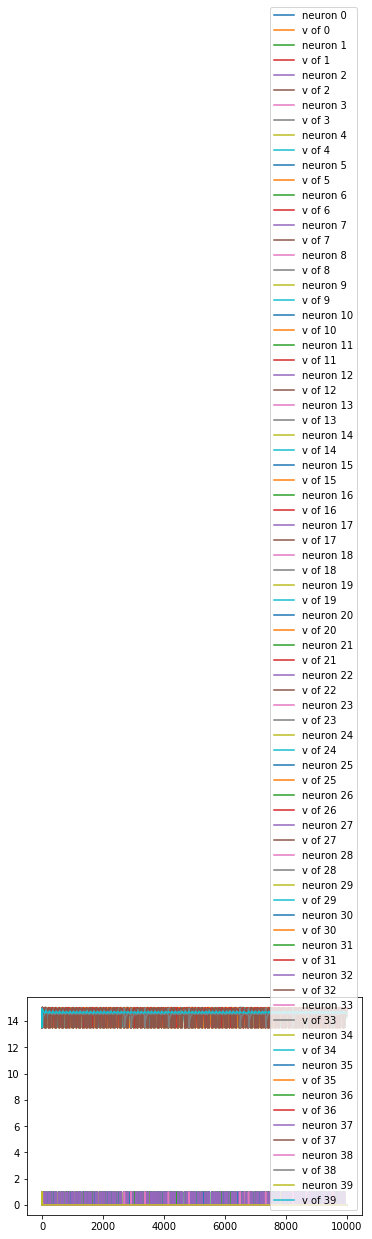

In [109]:
for i in range(N):
    plt.plot(times, v_t_fire[i, :], label='neuron {}'.format(i))
    plt.plot(times, v_t[i, :], label='v of {}'.format(i))

plt.legend(loc="lower right")

In [110]:
spikes = []

for j in range(N):
    spike = []
    for i in range(intT):
        if v_t_fire[j,i] == 1:
            spike.append(i)
            #print("{}th neuron fired spike appended".format(j))
    spikes.append(spike)
            
fig = plt.figure(figsize = (40, 10), dpi = 600)
ax = raster(spikes)
plt.title('small network raster plot')
plt.xlabel('time [sec]')
plt.ylabel('neuron')
fig.show()
plt.savefig("small network ext dynamic no-minus threshold raster plot.png")

/Users/soliton/.pyenv/versions/anaconda3-4.2.0/envs/dynamicsenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


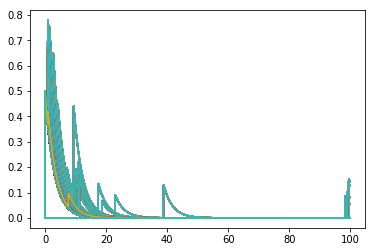

In [100]:
for j in range(N):
    for i in range(N):
        plt.plot(times[:1000], y_t[:1000, j, i], label='y')

In [41]:
for i in range(intT):
    if refrac_flag[0, i] == 1:
        print("{} fired / {} refrac period".format(v_t_fire[0, i], i))
    if v_t_fire[0, i] == 1:
        print("0th neuron fired at time {}".format(i))

0.0 fired / 9 refrac period
1.0 fired / 10 refrac period
0th neuron fired at time 10
0.0 fired / 11 refrac period
0.0 fired / 12 refrac period
0.0 fired / 13 refrac period
0.0 fired / 14 refrac period
0.0 fired / 15 refrac period
0.0 fired / 16 refrac period
0.0 fired / 17 refrac period
0.0 fired / 18 refrac period
0.0 fired / 19 refrac period
0.0 fired / 20 refrac period
0.0 fired / 21 refrac period
0.0 fired / 22 refrac period
0.0 fired / 23 refrac period
0.0 fired / 24 refrac period
0.0 fired / 25 refrac period
0.0 fired / 26 refrac period
0.0 fired / 27 refrac period
0.0 fired / 28 refrac period
0.0 fired / 29 refrac period
0.0 fired / 30 refrac period
0.0 fired / 31 refrac period
0.0 fired / 32 refrac period
0.0 fired / 33 refrac period
0.0 fired / 34 refrac period
0.0 fired / 35 refrac period
0.0 fired / 36 refrac period
0.0 fired / 37 refrac period
0.0 fired / 38 refrac period
0.0 fired / 54 refrac period
1.0 fired / 55 refrac period
0th neuron fired at time 55
0.0 fired / 56 re

1.0 fired / 2199 refrac period
0th neuron fired at time 2199
0.0 fired / 2200 refrac period
0.0 fired / 2201 refrac period
0.0 fired / 2202 refrac period
0.0 fired / 2203 refrac period
0.0 fired / 2204 refrac period
0.0 fired / 2205 refrac period
0.0 fired / 2206 refrac period
0.0 fired / 2207 refrac period
0.0 fired / 2208 refrac period
0.0 fired / 2209 refrac period
0.0 fired / 2210 refrac period
0.0 fired / 2211 refrac period
0.0 fired / 2212 refrac period
0.0 fired / 2213 refrac period
0.0 fired / 2214 refrac period
0.0 fired / 2215 refrac period
0.0 fired / 2216 refrac period
0.0 fired / 2217 refrac period
0.0 fired / 2218 refrac period
0.0 fired / 2219 refrac period
0.0 fired / 2220 refrac period
0.0 fired / 2221 refrac period
0.0 fired / 2222 refrac period
0.0 fired / 2223 refrac period
0.0 fired / 2224 refrac period
0.0 fired / 2225 refrac period
0.0 fired / 2226 refrac period
0.0 fired / 2227 refrac period
0.0 fired / 2228 refrac period
1.0 fired / 2229 refrac period
0th neuro

0.0 fired / 4134 refrac period
0.0 fired / 4135 refrac period
0.0 fired / 4136 refrac period
0.0 fired / 4137 refrac period
0.0 fired / 4138 refrac period
0.0 fired / 4139 refrac period
0.0 fired / 4140 refrac period
0.0 fired / 4141 refrac period
0.0 fired / 4142 refrac period
0.0 fired / 4143 refrac period
0.0 fired / 4144 refrac period
0.0 fired / 4145 refrac period
0.0 fired / 4146 refrac period
0.0 fired / 4147 refrac period
0.0 fired / 4148 refrac period
1.0 fired / 4149 refrac period
0th neuron fired at time 4149
0.0 fired / 4150 refrac period
0.0 fired / 4151 refrac period
0.0 fired / 4152 refrac period
0.0 fired / 4153 refrac period
0.0 fired / 4154 refrac period
0.0 fired / 4155 refrac period
0.0 fired / 4156 refrac period
0.0 fired / 4157 refrac period
0.0 fired / 4158 refrac period
0.0 fired / 4159 refrac period
0.0 fired / 4160 refrac period
0.0 fired / 4161 refrac period
0.0 fired / 4162 refrac period
0.0 fired / 4163 refrac period
0.0 fired / 4164 refrac period
0.0 fired

0.0 fired / 6552 refrac period
0.0 fired / 6553 refrac period
0.0 fired / 6554 refrac period
0.0 fired / 6555 refrac period
0.0 fired / 6556 refrac period
0.0 fired / 6557 refrac period
0.0 fired / 6558 refrac period
0.0 fired / 6559 refrac period
0.0 fired / 6560 refrac period
0.0 fired / 6561 refrac period
0.0 fired / 6562 refrac period
0.0 fired / 6563 refrac period
0.0 fired / 6564 refrac period
0.0 fired / 6565 refrac period
0.0 fired / 6566 refrac period
0.0 fired / 6567 refrac period
0.0 fired / 6568 refrac period
0.0 fired / 6569 refrac period
0.0 fired / 6570 refrac period
0.0 fired / 6571 refrac period
0.0 fired / 6572 refrac period
0.0 fired / 6573 refrac period
0.0 fired / 6574 refrac period
0.0 fired / 6575 refrac period
0.0 fired / 6576 refrac period
0.0 fired / 6577 refrac period
0.0 fired / 6578 refrac period
1.0 fired / 6579 refrac period
0th neuron fired at time 6579
0.0 fired / 6580 refrac period
0.0 fired / 6581 refrac period
0.0 fired / 6582 refrac period
0.0 fired

0.0 fired / 9456 refrac period
0.0 fired / 9457 refrac period
0.0 fired / 9458 refrac period
1.0 fired / 9459 refrac period
0th neuron fired at time 9459
0.0 fired / 9460 refrac period
0.0 fired / 9461 refrac period
0.0 fired / 9462 refrac period
0.0 fired / 9463 refrac period
0.0 fired / 9464 refrac period
0.0 fired / 9465 refrac period
0.0 fired / 9466 refrac period
0.0 fired / 9467 refrac period
0.0 fired / 9468 refrac period
0.0 fired / 9469 refrac period
0.0 fired / 9470 refrac period
0.0 fired / 9471 refrac period
0.0 fired / 9472 refrac period
0.0 fired / 9473 refrac period
0.0 fired / 9474 refrac period
0.0 fired / 9475 refrac period
0.0 fired / 9476 refrac period
0.0 fired / 9477 refrac period
0.0 fired / 9478 refrac period
0.0 fired / 9479 refrac period
0.0 fired / 9480 refrac period
0.0 fired / 9481 refrac period
0.0 fired / 9482 refrac period
0.0 fired / 9483 refrac period
0.0 fired / 9484 refrac period
0.0 fired / 9485 refrac period
0.0 fired / 9486 refrac period
0.0 fired

0.0 fired / 12358 refrac period
0.0 fired / 12359 refrac period
0.0 fired / 12360 refrac period
0.0 fired / 12361 refrac period
0.0 fired / 12362 refrac period
0.0 fired / 12363 refrac period
0.0 fired / 12364 refrac period
0.0 fired / 12365 refrac period
0.0 fired / 12366 refrac period
0.0 fired / 12367 refrac period
0.0 fired / 12368 refrac period
1.0 fired / 12369 refrac period
0th neuron fired at time 12369
0.0 fired / 12370 refrac period
0.0 fired / 12371 refrac period
0.0 fired / 12372 refrac period
0.0 fired / 12373 refrac period
0.0 fired / 12374 refrac period
0.0 fired / 12375 refrac period
0.0 fired / 12376 refrac period
0.0 fired / 12377 refrac period
0.0 fired / 12378 refrac period
0.0 fired / 12379 refrac period
0.0 fired / 12380 refrac period
0.0 fired / 12381 refrac period
0.0 fired / 12382 refrac period
0.0 fired / 12383 refrac period
0.0 fired / 12384 refrac period
0.0 fired / 12385 refrac period
0.0 fired / 12386 refrac period
0.0 fired / 12387 refrac period
0.0 fired

0.0 fired / 14777 refrac period
0.0 fired / 14778 refrac period
0.0 fired / 14779 refrac period
0.0 fired / 14780 refrac period
0.0 fired / 14781 refrac period
0.0 fired / 14782 refrac period
0.0 fired / 14783 refrac period
0.0 fired / 14784 refrac period
0.0 fired / 14785 refrac period
0.0 fired / 14786 refrac period
0.0 fired / 14787 refrac period
0.0 fired / 14788 refrac period
0.0 fired / 14789 refrac period
0.0 fired / 14790 refrac period
0.0 fired / 14791 refrac period
0.0 fired / 14792 refrac period
0.0 fired / 14793 refrac period
0.0 fired / 14794 refrac period
0.0 fired / 14795 refrac period
0.0 fired / 14796 refrac period
0.0 fired / 14797 refrac period
0.0 fired / 14798 refrac period
1.0 fired / 14799 refrac period
0th neuron fired at time 14799
0.0 fired / 14800 refrac period
0.0 fired / 14801 refrac period
0.0 fired / 14802 refrac period
0.0 fired / 14803 refrac period
0.0 fired / 14804 refrac period
0.0 fired / 14805 refrac period
0.0 fired / 14806 refrac period
0.0 fired

0.0 fired / 17442 refrac period
0.0 fired / 17443 refrac period
0.0 fired / 17444 refrac period
0.0 fired / 17445 refrac period
0.0 fired / 17446 refrac period
0.0 fired / 17447 refrac period
0.0 fired / 17448 refrac period
0.0 fired / 17449 refrac period
0.0 fired / 17450 refrac period
0.0 fired / 17451 refrac period
0.0 fired / 17452 refrac period
0.0 fired / 17453 refrac period
0.0 fired / 17454 refrac period
0.0 fired / 17455 refrac period
0.0 fired / 17456 refrac period
0.0 fired / 17457 refrac period
0.0 fired / 17458 refrac period
0.0 fired / 17459 refrac period
0.0 fired / 17460 refrac period
0.0 fired / 17461 refrac period
0.0 fired / 17462 refrac period
0.0 fired / 17463 refrac period
0.0 fired / 17464 refrac period
0.0 fired / 17465 refrac period
0.0 fired / 17466 refrac period
0.0 fired / 17467 refrac period
0.0 fired / 17468 refrac period
1.0 fired / 17469 refrac period
0th neuron fired at time 17469
0.0 fired / 17470 refrac period
0.0 fired / 17471 refrac period
0.0 fired

0.0 fired / 19615 refrac period
0.0 fired / 19616 refrac period
0.0 fired / 19617 refrac period
0.0 fired / 19618 refrac period
0.0 fired / 19619 refrac period
0.0 fired / 19620 refrac period
0.0 fired / 19621 refrac period
0.0 fired / 19622 refrac period
0.0 fired / 19623 refrac period
0.0 fired / 19624 refrac period
0.0 fired / 19625 refrac period
0.0 fired / 19626 refrac period
0.0 fired / 19627 refrac period
0.0 fired / 19628 refrac period
1.0 fired / 19629 refrac period
0th neuron fired at time 19629
0.0 fired / 19630 refrac period
0.0 fired / 19631 refrac period
0.0 fired / 19632 refrac period
0.0 fired / 19633 refrac period
0.0 fired / 19634 refrac period
0.0 fired / 19635 refrac period
0.0 fired / 19636 refrac period
0.0 fired / 19637 refrac period
0.0 fired / 19638 refrac period
0.0 fired / 19639 refrac period
0.0 fired / 19640 refrac period
0.0 fired / 19641 refrac period
0.0 fired / 19642 refrac period
0.0 fired / 19643 refrac period
0.0 fired / 19644 refrac period
0.0 fired

0.0 fired / 22517 refrac period
0.0 fired / 22518 refrac period
0.0 fired / 22519 refrac period
0.0 fired / 22520 refrac period
0.0 fired / 22521 refrac period
0.0 fired / 22522 refrac period
0.0 fired / 22523 refrac period
0.0 fired / 22524 refrac period
0.0 fired / 22525 refrac period
0.0 fired / 22526 refrac period
0.0 fired / 22527 refrac period
0.0 fired / 22528 refrac period
0.0 fired / 22529 refrac period
0.0 fired / 22530 refrac period
0.0 fired / 22531 refrac period
0.0 fired / 22532 refrac period
0.0 fired / 22533 refrac period
0.0 fired / 22534 refrac period
0.0 fired / 22535 refrac period
0.0 fired / 22536 refrac period
0.0 fired / 22537 refrac period
0.0 fired / 22538 refrac period
1.0 fired / 22539 refrac period
0th neuron fired at time 22539
0.0 fired / 22540 refrac period
0.0 fired / 22541 refrac period
0.0 fired / 22542 refrac period
0.0 fired / 22543 refrac period
0.0 fired / 22544 refrac period
0.0 fired / 22545 refrac period
0.0 fired / 22546 refrac period
0.0 fired

0.0 fired / 25420 refrac period
0.0 fired / 25421 refrac period
0.0 fired / 25422 refrac period
0.0 fired / 25423 refrac period
0.0 fired / 25424 refrac period
0.0 fired / 25425 refrac period
0.0 fired / 25426 refrac period
0.0 fired / 25427 refrac period
0.0 fired / 25428 refrac period
0.0 fired / 25429 refrac period
0.0 fired / 25430 refrac period
0.0 fired / 25431 refrac period
0.0 fired / 25432 refrac period
0.0 fired / 25433 refrac period
0.0 fired / 25434 refrac period
0.0 fired / 25435 refrac period
0.0 fired / 25436 refrac period
0.0 fired / 25437 refrac period
0.0 fired / 25438 refrac period
0.0 fired / 25439 refrac period
0.0 fired / 25440 refrac period
0.0 fired / 25441 refrac period
0.0 fired / 25442 refrac period
0.0 fired / 25443 refrac period
0.0 fired / 25444 refrac period
0.0 fired / 25445 refrac period
0.0 fired / 25446 refrac period
0.0 fired / 25447 refrac period
0.0 fired / 25448 refrac period
1.0 fired / 25449 refrac period
0th neuron fired at time 25449
0.0 fired

0.0 fired / 27839 refrac period
0.0 fired / 27840 refrac period
0.0 fired / 27841 refrac period
0.0 fired / 27842 refrac period
0.0 fired / 27843 refrac period
0.0 fired / 27844 refrac period
0.0 fired / 27845 refrac period
0.0 fired / 27846 refrac period
0.0 fired / 27847 refrac period
0.0 fired / 27848 refrac period
1.0 fired / 27849 refrac period
0th neuron fired at time 27849
0.0 fired / 27850 refrac period
0.0 fired / 27851 refrac period
0.0 fired / 27852 refrac period
0.0 fired / 27853 refrac period
0.0 fired / 27854 refrac period
0.0 fired / 27855 refrac period
0.0 fired / 27856 refrac period
0.0 fired / 27857 refrac period
0.0 fired / 27858 refrac period
0.0 fired / 27859 refrac period
0.0 fired / 27860 refrac period
0.0 fired / 27861 refrac period
0.0 fired / 27862 refrac period
0.0 fired / 27863 refrac period
0.0 fired / 27864 refrac period
0.0 fired / 27865 refrac period
0.0 fired / 27866 refrac period
0.0 fired / 27867 refrac period
0.0 fired / 27868 refrac period
0.0 fired

0.0 fired / 30258 refrac period
0.0 fired / 30259 refrac period
0.0 fired / 30260 refrac period
0.0 fired / 30261 refrac period
0.0 fired / 30262 refrac period
0.0 fired / 30263 refrac period
0.0 fired / 30264 refrac period
0.0 fired / 30265 refrac period
0.0 fired / 30266 refrac period
0.0 fired / 30267 refrac period
0.0 fired / 30268 refrac period
0.0 fired / 30269 refrac period
0.0 fired / 30270 refrac period
0.0 fired / 30271 refrac period
0.0 fired / 30272 refrac period
0.0 fired / 30273 refrac period
0.0 fired / 30274 refrac period
0.0 fired / 30275 refrac period
0.0 fired / 30276 refrac period
0.0 fired / 30277 refrac period
0.0 fired / 30278 refrac period
1.0 fired / 30279 refrac period
0th neuron fired at time 30279
0.0 fired / 30280 refrac period
0.0 fired / 30281 refrac period
0.0 fired / 30282 refrac period
0.0 fired / 30283 refrac period
0.0 fired / 30284 refrac period
0.0 fired / 30285 refrac period
0.0 fired / 30286 refrac period
0.0 fired / 30287 refrac period
0.0 fired

0.0 fired / 32447 refrac period
0.0 fired / 32448 refrac period
0.0 fired / 32449 refrac period
0.0 fired / 32450 refrac period
0.0 fired / 32451 refrac period
0.0 fired / 32452 refrac period
0.0 fired / 32453 refrac period
0.0 fired / 32454 refrac period
0.0 fired / 32455 refrac period
0.0 fired / 32456 refrac period
0.0 fired / 32457 refrac period
0.0 fired / 32458 refrac period
0.0 fired / 32459 refrac period
0.0 fired / 32460 refrac period
0.0 fired / 32461 refrac period
0.0 fired / 32462 refrac period
0.0 fired / 32463 refrac period
0.0 fired / 32464 refrac period
0.0 fired / 32465 refrac period
0.0 fired / 32466 refrac period
0.0 fired / 32467 refrac period
0.0 fired / 32468 refrac period
1.0 fired / 32469 refrac period
0th neuron fired at time 32469
0.0 fired / 32470 refrac period
0.0 fired / 32471 refrac period
0.0 fired / 32472 refrac period
0.0 fired / 32473 refrac period
0.0 fired / 32474 refrac period
0.0 fired / 32475 refrac period
0.0 fired / 32476 refrac period
0.0 fired

0.0 fired / 34707 refrac period
0.0 fired / 34708 refrac period
0.0 fired / 34709 refrac period
0.0 fired / 34710 refrac period
0.0 fired / 34711 refrac period
0.0 fired / 34712 refrac period
0.0 fired / 34713 refrac period
0.0 fired / 34714 refrac period
0.0 fired / 34715 refrac period
0.0 fired / 34716 refrac period
0.0 fired / 34717 refrac period
0.0 fired / 34718 refrac period
1.0 fired / 34719 refrac period
0th neuron fired at time 34719
0.0 fired / 34720 refrac period
0.0 fired / 34721 refrac period
0.0 fired / 34722 refrac period
0.0 fired / 34723 refrac period
0.0 fired / 34724 refrac period
0.0 fired / 34725 refrac period
0.0 fired / 34726 refrac period
0.0 fired / 34727 refrac period
0.0 fired / 34728 refrac period
0.0 fired / 34729 refrac period
0.0 fired / 34730 refrac period
0.0 fired / 34731 refrac period
0.0 fired / 34732 refrac period
0.0 fired / 34733 refrac period
0.0 fired / 34734 refrac period
0.0 fired / 34735 refrac period
0.0 fired / 34736 refrac period
0.0 fired

0.0 fired / 37030 refrac period
0.0 fired / 37031 refrac period
0.0 fired / 37032 refrac period
0.0 fired / 37033 refrac period
0.0 fired / 37034 refrac period
0.0 fired / 37035 refrac period
0.0 fired / 37036 refrac period
0.0 fired / 37037 refrac period
0.0 fired / 37038 refrac period
0.0 fired / 37039 refrac period
0.0 fired / 37040 refrac period
0.0 fired / 37041 refrac period
0.0 fired / 37042 refrac period
0.0 fired / 37043 refrac period
0.0 fired / 37044 refrac period
0.0 fired / 37045 refrac period
0.0 fired / 37046 refrac period
0.0 fired / 37047 refrac period
0.0 fired / 37048 refrac period
0.0 fired / 37049 refrac period
0.0 fired / 37050 refrac period
0.0 fired / 37051 refrac period
0.0 fired / 37052 refrac period
0.0 fired / 37053 refrac period
0.0 fired / 37054 refrac period
0.0 fired / 37055 refrac period
0.0 fired / 37056 refrac period
0.0 fired / 37057 refrac period
0.0 fired / 37058 refrac period
1.0 fired / 37059 refrac period
0th neuron fired at time 37059
0.0 fired

0.0 fired / 39450 refrac period
0.0 fired / 39451 refrac period
0.0 fired / 39452 refrac period
0.0 fired / 39453 refrac period
0.0 fired / 39454 refrac period
0.0 fired / 39455 refrac period
0.0 fired / 39456 refrac period
0.0 fired / 39457 refrac period
0.0 fired / 39458 refrac period
1.0 fired / 39459 refrac period
0th neuron fired at time 39459
0.0 fired / 39460 refrac period
0.0 fired / 39461 refrac period
0.0 fired / 39462 refrac period
0.0 fired / 39463 refrac period
0.0 fired / 39464 refrac period
0.0 fired / 39465 refrac period
0.0 fired / 39466 refrac period
0.0 fired / 39467 refrac period
0.0 fired / 39468 refrac period
0.0 fired / 39469 refrac period
0.0 fired / 39470 refrac period
0.0 fired / 39471 refrac period
0.0 fired / 39472 refrac period
0.0 fired / 39473 refrac period
0.0 fired / 39474 refrac period
0.0 fired / 39475 refrac period
0.0 fired / 39476 refrac period
0.0 fired / 39477 refrac period
0.0 fired / 39478 refrac period
0.0 fired / 39479 refrac period
0.0 fired

0.0 fired / 41868 refrac period
0.0 fired / 41869 refrac period
0.0 fired / 41870 refrac period
0.0 fired / 41871 refrac period
0.0 fired / 41872 refrac period
0.0 fired / 41873 refrac period
0.0 fired / 41874 refrac period
0.0 fired / 41875 refrac period
0.0 fired / 41876 refrac period
0.0 fired / 41877 refrac period
0.0 fired / 41878 refrac period
0.0 fired / 41879 refrac period
0.0 fired / 41880 refrac period
0.0 fired / 41881 refrac period
0.0 fired / 41882 refrac period
0.0 fired / 41883 refrac period
0.0 fired / 41884 refrac period
0.0 fired / 41885 refrac period
0.0 fired / 41886 refrac period
0.0 fired / 41887 refrac period
0.0 fired / 41888 refrac period
1.0 fired / 41889 refrac period
0th neuron fired at time 41889
0.0 fired / 41890 refrac period
0.0 fired / 41891 refrac period
0.0 fired / 41892 refrac period
0.0 fired / 41893 refrac period
0.0 fired / 41894 refrac period
0.0 fired / 41895 refrac period
0.0 fired / 41896 refrac period
0.0 fired / 41897 refrac period
0.0 fired

0.0 fired / 44288 refrac period
1.0 fired / 44289 refrac period
0th neuron fired at time 44289
0.0 fired / 44290 refrac period
0.0 fired / 44291 refrac period
0.0 fired / 44292 refrac period
0.0 fired / 44293 refrac period
0.0 fired / 44294 refrac period
0.0 fired / 44295 refrac period
0.0 fired / 44296 refrac period
0.0 fired / 44297 refrac period
0.0 fired / 44298 refrac period
0.0 fired / 44299 refrac period
0.0 fired / 44300 refrac period
0.0 fired / 44301 refrac period
0.0 fired / 44302 refrac period
0.0 fired / 44303 refrac period
0.0 fired / 44304 refrac period
0.0 fired / 44305 refrac period
0.0 fired / 44306 refrac period
0.0 fired / 44307 refrac period
0.0 fired / 44308 refrac period
0.0 fired / 44309 refrac period
0.0 fired / 44310 refrac period
0.0 fired / 44311 refrac period
0.0 fired / 44312 refrac period
0.0 fired / 44313 refrac period
0.0 fired / 44314 refrac period
0.0 fired / 44315 refrac period
0.0 fired / 44316 refrac period
0.0 fired / 44317 refrac period
0.0 fired

0.0 fired / 46706 refrac period
0.0 fired / 46707 refrac period
0.0 fired / 46708 refrac period
0.0 fired / 46709 refrac period
0.0 fired / 46710 refrac period
0.0 fired / 46711 refrac period
0.0 fired / 46712 refrac period
0.0 fired / 46713 refrac period
0.0 fired / 46714 refrac period
0.0 fired / 46715 refrac period
0.0 fired / 46716 refrac period
0.0 fired / 46717 refrac period
0.0 fired / 46718 refrac period
1.0 fired / 46719 refrac period
0th neuron fired at time 46719
0.0 fired / 46720 refrac period
0.0 fired / 46721 refrac period
0.0 fired / 46722 refrac period
0.0 fired / 46723 refrac period
0.0 fired / 46724 refrac period
0.0 fired / 46725 refrac period
0.0 fired / 46726 refrac period
0.0 fired / 46727 refrac period
0.0 fired / 46728 refrac period
0.0 fired / 46729 refrac period
0.0 fired / 46730 refrac period
0.0 fired / 46731 refrac period
0.0 fired / 46732 refrac period
0.0 fired / 46733 refrac period
0.0 fired / 46734 refrac period
0.0 fired / 46735 refrac period
0.0 fired

0.0 fired / 48641 refrac period
0.0 fired / 48642 refrac period
0.0 fired / 48643 refrac period
0.0 fired / 48644 refrac period
0.0 fired / 48645 refrac period
0.0 fired / 48646 refrac period
0.0 fired / 48647 refrac period
0.0 fired / 48648 refrac period
0.0 fired / 48649 refrac period
0.0 fired / 48650 refrac period
0.0 fired / 48651 refrac period
0.0 fired / 48652 refrac period
0.0 fired / 48653 refrac period
0.0 fired / 48654 refrac period
0.0 fired / 48655 refrac period
0.0 fired / 48656 refrac period
0.0 fired / 48657 refrac period
0.0 fired / 48658 refrac period
0.0 fired / 48659 refrac period
0.0 fired / 48660 refrac period
0.0 fired / 48661 refrac period
0.0 fired / 48662 refrac period
0.0 fired / 48663 refrac period
0.0 fired / 48664 refrac period
0.0 fired / 48665 refrac period
0.0 fired / 48666 refrac period
0.0 fired / 48667 refrac period
0.0 fired / 48668 refrac period
1.0 fired / 48669 refrac period
0th neuron fired at time 48669
0.0 fired / 48670 refrac period
0.0 fired

0.0 fired / 51060 refrac period
0.0 fired / 51061 refrac period
0.0 fired / 51062 refrac period
0.0 fired / 51063 refrac period
0.0 fired / 51064 refrac period
0.0 fired / 51065 refrac period
0.0 fired / 51066 refrac period
0.0 fired / 51067 refrac period
0.0 fired / 51068 refrac period
1.0 fired / 51069 refrac period
0th neuron fired at time 51069
0.0 fired / 51070 refrac period
0.0 fired / 51071 refrac period
0.0 fired / 51072 refrac period
0.0 fired / 51073 refrac period
0.0 fired / 51074 refrac period
0.0 fired / 51075 refrac period
0.0 fired / 51076 refrac period
0.0 fired / 51077 refrac period
0.0 fired / 51078 refrac period
0.0 fired / 51079 refrac period
0.0 fired / 51080 refrac period
0.0 fired / 51081 refrac period
0.0 fired / 51082 refrac period
0.0 fired / 51083 refrac period
0.0 fired / 51084 refrac period
0.0 fired / 51085 refrac period
0.0 fired / 51086 refrac period
0.0 fired / 51087 refrac period
0.0 fired / 51088 refrac period
0.0 fired / 51089 refrac period
0.0 fired

0.0 fired / 53479 refrac period
0.0 fired / 53480 refrac period
0.0 fired / 53481 refrac period
0.0 fired / 53482 refrac period
0.0 fired / 53483 refrac period
0.0 fired / 53484 refrac period
0.0 fired / 53485 refrac period
0.0 fired / 53486 refrac period
0.0 fired / 53487 refrac period
0.0 fired / 53488 refrac period
0.0 fired / 53489 refrac period
0.0 fired / 53490 refrac period
0.0 fired / 53491 refrac period
0.0 fired / 53492 refrac period
0.0 fired / 53493 refrac period
0.0 fired / 53494 refrac period
0.0 fired / 53495 refrac period
0.0 fired / 53496 refrac period
0.0 fired / 53497 refrac period
0.0 fired / 53498 refrac period
1.0 fired / 53499 refrac period
0th neuron fired at time 53499
0.0 fired / 53500 refrac period
0.0 fired / 53501 refrac period
0.0 fired / 53502 refrac period
0.0 fired / 53503 refrac period
0.0 fired / 53504 refrac period
0.0 fired / 53505 refrac period
0.0 fired / 53506 refrac period
0.0 fired / 53507 refrac period
0.0 fired / 53508 refrac period
0.0 fired

0.0 fired / 55898 refrac period
1.0 fired / 55899 refrac period
0th neuron fired at time 55899
0.0 fired / 55900 refrac period
0.0 fired / 55901 refrac period
0.0 fired / 55902 refrac period
0.0 fired / 55903 refrac period
0.0 fired / 55904 refrac period
0.0 fired / 55905 refrac period
0.0 fired / 55906 refrac period
0.0 fired / 55907 refrac period
0.0 fired / 55908 refrac period
0.0 fired / 55909 refrac period
0.0 fired / 55910 refrac period
0.0 fired / 55911 refrac period
0.0 fired / 55912 refrac period
0.0 fired / 55913 refrac period
0.0 fired / 55914 refrac period
0.0 fired / 55915 refrac period
0.0 fired / 55916 refrac period
0.0 fired / 55917 refrac period
0.0 fired / 55918 refrac period
0.0 fired / 55919 refrac period
0.0 fired / 55920 refrac period
0.0 fired / 55921 refrac period
0.0 fired / 55922 refrac period
0.0 fired / 55923 refrac period
0.0 fired / 55924 refrac period
0.0 fired / 55925 refrac period
0.0 fired / 55926 refrac period
0.0 fired / 55927 refrac period
0.0 fired

0.0 fired / 57833 refrac period
0.0 fired / 57834 refrac period
0.0 fired / 57835 refrac period
0.0 fired / 57836 refrac period
0.0 fired / 57837 refrac period
0.0 fired / 57838 refrac period
0.0 fired / 57839 refrac period
0.0 fired / 57840 refrac period
0.0 fired / 57841 refrac period
0.0 fired / 57842 refrac period
0.0 fired / 57843 refrac period
0.0 fired / 57844 refrac period
0.0 fired / 57845 refrac period
0.0 fired / 57846 refrac period
0.0 fired / 57847 refrac period
0.0 fired / 57848 refrac period
1.0 fired / 57849 refrac period
0th neuron fired at time 57849
0.0 fired / 57850 refrac period
0.0 fired / 57851 refrac period
0.0 fired / 57852 refrac period
0.0 fired / 57853 refrac period
0.0 fired / 57854 refrac period
0.0 fired / 57855 refrac period
0.0 fired / 57856 refrac period
0.0 fired / 57857 refrac period
0.0 fired / 57858 refrac period
0.0 fired / 57859 refrac period
0.0 fired / 57860 refrac period
0.0 fired / 57861 refrac period
0.0 fired / 57862 refrac period
0.0 fired

0.0 fired / 60251 refrac period
0.0 fired / 60252 refrac period
0.0 fired / 60253 refrac period
0.0 fired / 60254 refrac period
0.0 fired / 60255 refrac period
0.0 fired / 60256 refrac period
0.0 fired / 60257 refrac period
0.0 fired / 60258 refrac period
0.0 fired / 60259 refrac period
0.0 fired / 60260 refrac period
0.0 fired / 60261 refrac period
0.0 fired / 60262 refrac period
0.0 fired / 60263 refrac period
0.0 fired / 60264 refrac period
0.0 fired / 60265 refrac period
0.0 fired / 60266 refrac period
0.0 fired / 60267 refrac period
0.0 fired / 60268 refrac period
0.0 fired / 60269 refrac period
0.0 fired / 60270 refrac period
0.0 fired / 60271 refrac period
0.0 fired / 60272 refrac period
0.0 fired / 60273 refrac period
0.0 fired / 60274 refrac period
0.0 fired / 60275 refrac period
0.0 fired / 60276 refrac period
0.0 fired / 60277 refrac period
0.0 fired / 60278 refrac period
1.0 fired / 60279 refrac period
0th neuron fired at time 60279
0.0 fired / 60280 refrac period
0.0 fired

0.0 fired / 62671 refrac period
0.0 fired / 62672 refrac period
0.0 fired / 62673 refrac period
0.0 fired / 62674 refrac period
0.0 fired / 62675 refrac period
0.0 fired / 62676 refrac period
0.0 fired / 62677 refrac period
0.0 fired / 62678 refrac period
1.0 fired / 62679 refrac period
0th neuron fired at time 62679
0.0 fired / 62680 refrac period
0.0 fired / 62681 refrac period
0.0 fired / 62682 refrac period
0.0 fired / 62683 refrac period
0.0 fired / 62684 refrac period
0.0 fired / 62685 refrac period
0.0 fired / 62686 refrac period
0.0 fired / 62687 refrac period
0.0 fired / 62688 refrac period
0.0 fired / 62689 refrac period
0.0 fired / 62690 refrac period
0.0 fired / 62691 refrac period
0.0 fired / 62692 refrac period
0.0 fired / 62693 refrac period
0.0 fired / 62694 refrac period
0.0 fired / 62695 refrac period
0.0 fired / 62696 refrac period
0.0 fired / 62697 refrac period
0.0 fired / 62698 refrac period
0.0 fired / 62699 refrac period
0.0 fired / 62700 refrac period
0.0 fired

0.0 fired / 65089 refrac period
0.0 fired / 65090 refrac period
0.0 fired / 65091 refrac period
0.0 fired / 65092 refrac period
0.0 fired / 65093 refrac period
0.0 fired / 65094 refrac period
0.0 fired / 65095 refrac period
0.0 fired / 65096 refrac period
0.0 fired / 65097 refrac period
0.0 fired / 65098 refrac period
0.0 fired / 65099 refrac period
0.0 fired / 65100 refrac period
0.0 fired / 65101 refrac period
0.0 fired / 65102 refrac period
0.0 fired / 65103 refrac period
0.0 fired / 65104 refrac period
0.0 fired / 65105 refrac period
0.0 fired / 65106 refrac period
0.0 fired / 65107 refrac period
0.0 fired / 65108 refrac period
1.0 fired / 65109 refrac period
0th neuron fired at time 65109
0.0 fired / 65110 refrac period
0.0 fired / 65111 refrac period
0.0 fired / 65112 refrac period
0.0 fired / 65113 refrac period
0.0 fired / 65114 refrac period
0.0 fired / 65115 refrac period
0.0 fired / 65116 refrac period
0.0 fired / 65117 refrac period
0.0 fired / 65118 refrac period
0.0 fired

1.0 fired / 67509 refrac period
0th neuron fired at time 67509
0.0 fired / 67510 refrac period
0.0 fired / 67511 refrac period
0.0 fired / 67512 refrac period
0.0 fired / 67513 refrac period
0.0 fired / 67514 refrac period
0.0 fired / 67515 refrac period
0.0 fired / 67516 refrac period
0.0 fired / 67517 refrac period
0.0 fired / 67518 refrac period
0.0 fired / 67519 refrac period
0.0 fired / 67520 refrac period
0.0 fired / 67521 refrac period
0.0 fired / 67522 refrac period
0.0 fired / 67523 refrac period
0.0 fired / 67524 refrac period
0.0 fired / 67525 refrac period
0.0 fired / 67526 refrac period
0.0 fired / 67527 refrac period
0.0 fired / 67528 refrac period
0.0 fired / 67529 refrac period
0.0 fired / 67530 refrac period
0.0 fired / 67531 refrac period
0.0 fired / 67532 refrac period
0.0 fired / 67533 refrac period
0.0 fired / 67534 refrac period
0.0 fired / 67535 refrac period
0.0 fired / 67536 refrac period
0.0 fired / 67537 refrac period
0.0 fired / 67538 refrac period
1.0 fired

0.0 fired / 69927 refrac period
0.0 fired / 69928 refrac period
0.0 fired / 69929 refrac period
0.0 fired / 69930 refrac period
0.0 fired / 69931 refrac period
0.0 fired / 69932 refrac period
0.0 fired / 69933 refrac period
0.0 fired / 69934 refrac period
0.0 fired / 69935 refrac period
0.0 fired / 69936 refrac period
0.0 fired / 69937 refrac period
0.0 fired / 69938 refrac period
1.0 fired / 69939 refrac period
0th neuron fired at time 69939
0.0 fired / 69940 refrac period
0.0 fired / 69941 refrac period
0.0 fired / 69942 refrac period
0.0 fired / 69943 refrac period
0.0 fired / 69944 refrac period
0.0 fired / 69945 refrac period
0.0 fired / 69946 refrac period
0.0 fired / 69947 refrac period
0.0 fired / 69948 refrac period
0.0 fired / 69949 refrac period
0.0 fired / 69950 refrac period
0.0 fired / 69951 refrac period
0.0 fired / 69952 refrac period
0.0 fired / 69953 refrac period
0.0 fired / 69954 refrac period
0.0 fired / 69955 refrac period
0.0 fired / 69956 refrac period
0.0 fired

0.0 fired / 72346 refrac period
0.0 fired / 72347 refrac period
0.0 fired / 72348 refrac period
0.0 fired / 72349 refrac period
0.0 fired / 72350 refrac period
0.0 fired / 72351 refrac period
0.0 fired / 72352 refrac period
0.0 fired / 72353 refrac period
0.0 fired / 72354 refrac period
0.0 fired / 72355 refrac period
0.0 fired / 72356 refrac period
0.0 fired / 72357 refrac period
0.0 fired / 72358 refrac period
0.0 fired / 72359 refrac period
0.0 fired / 72360 refrac period
0.0 fired / 72361 refrac period
0.0 fired / 72362 refrac period
0.0 fired / 72363 refrac period
0.0 fired / 72364 refrac period
0.0 fired / 72365 refrac period
0.0 fired / 72366 refrac period
0.0 fired / 72367 refrac period
0.0 fired / 72368 refrac period
1.0 fired / 72369 refrac period
0th neuron fired at time 72369
0.0 fired / 72370 refrac period
0.0 fired / 72371 refrac period
0.0 fired / 72372 refrac period
0.0 fired / 72373 refrac period
0.0 fired / 72374 refrac period
0.0 fired / 72375 refrac period
0.0 fired

0.0 fired / 74765 refrac period
0.0 fired / 74766 refrac period
0.0 fired / 74767 refrac period
0.0 fired / 74768 refrac period
1.0 fired / 74769 refrac period
0th neuron fired at time 74769
0.0 fired / 74770 refrac period
0.0 fired / 74771 refrac period
0.0 fired / 74772 refrac period
0.0 fired / 74773 refrac period
0.0 fired / 74774 refrac period
0.0 fired / 74775 refrac period
0.0 fired / 74776 refrac period
0.0 fired / 74777 refrac period
0.0 fired / 74778 refrac period
0.0 fired / 74779 refrac period
0.0 fired / 74780 refrac period
0.0 fired / 74781 refrac period
0.0 fired / 74782 refrac period
0.0 fired / 74783 refrac period
0.0 fired / 74784 refrac period
0.0 fired / 74785 refrac period
0.0 fired / 74786 refrac period
0.0 fired / 74787 refrac period
0.0 fired / 74788 refrac period
0.0 fired / 74789 refrac period
0.0 fired / 74790 refrac period
0.0 fired / 74791 refrac period
0.0 fired / 74792 refrac period
0.0 fired / 74793 refrac period
0.0 fired / 74794 refrac period
0.0 fired

0.0 fired / 76700 refrac period
0.0 fired / 76701 refrac period
0.0 fired / 76702 refrac period
0.0 fired / 76703 refrac period
0.0 fired / 76704 refrac period
0.0 fired / 76705 refrac period
0.0 fired / 76706 refrac period
0.0 fired / 76707 refrac period
0.0 fired / 76708 refrac period
0.0 fired / 76709 refrac period
0.0 fired / 76710 refrac period
0.0 fired / 76711 refrac period
0.0 fired / 76712 refrac period
0.0 fired / 76713 refrac period
0.0 fired / 76714 refrac period
0.0 fired / 76715 refrac period
0.0 fired / 76716 refrac period
0.0 fired / 76717 refrac period
0.0 fired / 76718 refrac period
1.0 fired / 76719 refrac period
0th neuron fired at time 76719
0.0 fired / 76720 refrac period
0.0 fired / 76721 refrac period
0.0 fired / 76722 refrac period
0.0 fired / 76723 refrac period
0.0 fired / 76724 refrac period
0.0 fired / 76725 refrac period
0.0 fired / 76726 refrac period
0.0 fired / 76727 refrac period
0.0 fired / 76728 refrac period
0.0 fired / 76729 refrac period
0.0 fired

0.0 fired / 78635 refrac period
0.0 fired / 78636 refrac period
0.0 fired / 78637 refrac period
0.0 fired / 78638 refrac period
1.0 fired / 78639 refrac period
0th neuron fired at time 78639
0.0 fired / 78640 refrac period
0.0 fired / 78641 refrac period
0.0 fired / 78642 refrac period
0.0 fired / 78643 refrac period
0.0 fired / 78644 refrac period
0.0 fired / 78645 refrac period
0.0 fired / 78646 refrac period
0.0 fired / 78647 refrac period
0.0 fired / 78648 refrac period
0.0 fired / 78649 refrac period
0.0 fired / 78650 refrac period
0.0 fired / 78651 refrac period
0.0 fired / 78652 refrac period
0.0 fired / 78653 refrac period
0.0 fired / 78654 refrac period
0.0 fired / 78655 refrac period
0.0 fired / 78656 refrac period
0.0 fired / 78657 refrac period
0.0 fired / 78658 refrac period
0.0 fired / 78659 refrac period
0.0 fired / 78660 refrac period
0.0 fired / 78661 refrac period
0.0 fired / 78662 refrac period
0.0 fired / 78663 refrac period
0.0 fired / 78664 refrac period
0.0 fired

0.0 fired / 80570 refrac period
0.0 fired / 80571 refrac period
0.0 fired / 80572 refrac period
0.0 fired / 80573 refrac period
0.0 fired / 80574 refrac period
0.0 fired / 80575 refrac period
0.0 fired / 80576 refrac period
0.0 fired / 80577 refrac period
0.0 fired / 80578 refrac period
0.0 fired / 80579 refrac period
0.0 fired / 80580 refrac period
0.0 fired / 80581 refrac period
0.0 fired / 80582 refrac period
0.0 fired / 80583 refrac period
0.0 fired / 80584 refrac period
0.0 fired / 80585 refrac period
0.0 fired / 80586 refrac period
0.0 fired / 80587 refrac period
0.0 fired / 80588 refrac period
1.0 fired / 80589 refrac period
0th neuron fired at time 80589
0.0 fired / 80590 refrac period
0.0 fired / 80591 refrac period
0.0 fired / 80592 refrac period
0.0 fired / 80593 refrac period
0.0 fired / 80594 refrac period
0.0 fired / 80595 refrac period
0.0 fired / 80596 refrac period
0.0 fired / 80597 refrac period
0.0 fired / 80598 refrac period
0.0 fired / 80599 refrac period
0.0 fired

0.0 fired / 82505 refrac period
0.0 fired / 82506 refrac period
0.0 fired / 82507 refrac period
0.0 fired / 82508 refrac period
1.0 fired / 82509 refrac period
0th neuron fired at time 82509
0.0 fired / 82510 refrac period
0.0 fired / 82511 refrac period
0.0 fired / 82512 refrac period
0.0 fired / 82513 refrac period
0.0 fired / 82514 refrac period
0.0 fired / 82515 refrac period
0.0 fired / 82516 refrac period
0.0 fired / 82517 refrac period
0.0 fired / 82518 refrac period
0.0 fired / 82519 refrac period
0.0 fired / 82520 refrac period
0.0 fired / 82521 refrac period
0.0 fired / 82522 refrac period
0.0 fired / 82523 refrac period
0.0 fired / 82524 refrac period
0.0 fired / 82525 refrac period
0.0 fired / 82526 refrac period
0.0 fired / 82527 refrac period
0.0 fired / 82528 refrac period
0.0 fired / 82529 refrac period
0.0 fired / 82530 refrac period
0.0 fired / 82531 refrac period
0.0 fired / 82532 refrac period
0.0 fired / 82533 refrac period
0.0 fired / 82534 refrac period
0.0 fired

0.0 fired / 84440 refrac period
0.0 fired / 84441 refrac period
0.0 fired / 84442 refrac period
0.0 fired / 84443 refrac period
0.0 fired / 84444 refrac period
0.0 fired / 84445 refrac period
0.0 fired / 84446 refrac period
0.0 fired / 84447 refrac period
0.0 fired / 84448 refrac period
0.0 fired / 84449 refrac period
0.0 fired / 84450 refrac period
0.0 fired / 84451 refrac period
0.0 fired / 84452 refrac period
0.0 fired / 84453 refrac period
0.0 fired / 84454 refrac period
0.0 fired / 84455 refrac period
0.0 fired / 84456 refrac period
0.0 fired / 84457 refrac period
0.0 fired / 84458 refrac period
1.0 fired / 84459 refrac period
0th neuron fired at time 84459
0.0 fired / 84460 refrac period
0.0 fired / 84461 refrac period
0.0 fired / 84462 refrac period
0.0 fired / 84463 refrac period
0.0 fired / 84464 refrac period
0.0 fired / 84465 refrac period
0.0 fired / 84466 refrac period
0.0 fired / 84467 refrac period
0.0 fired / 84468 refrac period
0.0 fired / 84469 refrac period
0.0 fired

0.0 fired / 86375 refrac period
0.0 fired / 86376 refrac period
0.0 fired / 86377 refrac period
0.0 fired / 86378 refrac period
1.0 fired / 86379 refrac period
0th neuron fired at time 86379
0.0 fired / 86380 refrac period
0.0 fired / 86381 refrac period
0.0 fired / 86382 refrac period
0.0 fired / 86383 refrac period
0.0 fired / 86384 refrac period
0.0 fired / 86385 refrac period
0.0 fired / 86386 refrac period
0.0 fired / 86387 refrac period
0.0 fired / 86388 refrac period
0.0 fired / 86389 refrac period
0.0 fired / 86390 refrac period
0.0 fired / 86391 refrac period
0.0 fired / 86392 refrac period
0.0 fired / 86393 refrac period
0.0 fired / 86394 refrac period
0.0 fired / 86395 refrac period
0.0 fired / 86396 refrac period
0.0 fired / 86397 refrac period
0.0 fired / 86398 refrac period
0.0 fired / 86399 refrac period
0.0 fired / 86400 refrac period
0.0 fired / 86401 refrac period
0.0 fired / 86402 refrac period
0.0 fired / 86403 refrac period
0.0 fired / 86404 refrac period
0.0 fired

0.0 fired / 88794 refrac period
0.0 fired / 88795 refrac period
0.0 fired / 88796 refrac period
0.0 fired / 88797 refrac period
0.0 fired / 88798 refrac period
0.0 fired / 88799 refrac period
0.0 fired / 88800 refrac period
0.0 fired / 88801 refrac period
0.0 fired / 88802 refrac period
0.0 fired / 88803 refrac period
0.0 fired / 88804 refrac period
0.0 fired / 88805 refrac period
0.0 fired / 88806 refrac period
0.0 fired / 88807 refrac period
0.0 fired / 88808 refrac period
1.0 fired / 88809 refrac period
0th neuron fired at time 88809
0.0 fired / 88810 refrac period
0.0 fired / 88811 refrac period
0.0 fired / 88812 refrac period
0.0 fired / 88813 refrac period
0.0 fired / 88814 refrac period
0.0 fired / 88815 refrac period
0.0 fired / 88816 refrac period
0.0 fired / 88817 refrac period
0.0 fired / 88818 refrac period
0.0 fired / 88819 refrac period
0.0 fired / 88820 refrac period
0.0 fired / 88821 refrac period
0.0 fired / 88822 refrac period
0.0 fired / 88823 refrac period
0.0 fired

0.0 fired / 91212 refrac period
0.0 fired / 91213 refrac period
0.0 fired / 91214 refrac period
0.0 fired / 91215 refrac period
0.0 fired / 91216 refrac period
0.0 fired / 91217 refrac period
0.0 fired / 91218 refrac period
0.0 fired / 91219 refrac period
0.0 fired / 91220 refrac period
0.0 fired / 91221 refrac period
0.0 fired / 91222 refrac period
0.0 fired / 91223 refrac period
0.0 fired / 91224 refrac period
0.0 fired / 91225 refrac period
0.0 fired / 91226 refrac period
0.0 fired / 91227 refrac period
0.0 fired / 91228 refrac period
0.0 fired / 91229 refrac period
0.0 fired / 91230 refrac period
0.0 fired / 91231 refrac period
0.0 fired / 91232 refrac period
0.0 fired / 91233 refrac period
0.0 fired / 91234 refrac period
0.0 fired / 91235 refrac period
0.0 fired / 91236 refrac period
0.0 fired / 91237 refrac period
0.0 fired / 91238 refrac period
1.0 fired / 91239 refrac period
0th neuron fired at time 91239
0.0 fired / 91240 refrac period
0.0 fired / 91241 refrac period
0.0 fired

0.0 fired / 93632 refrac period
0.0 fired / 93633 refrac period
0.0 fired / 93634 refrac period
0.0 fired / 93635 refrac period
0.0 fired / 93636 refrac period
0.0 fired / 93637 refrac period
0.0 fired / 93638 refrac period
1.0 fired / 93639 refrac period
0th neuron fired at time 93639
0.0 fired / 93640 refrac period
0.0 fired / 93641 refrac period
0.0 fired / 93642 refrac period
0.0 fired / 93643 refrac period
0.0 fired / 93644 refrac period
0.0 fired / 93645 refrac period
0.0 fired / 93646 refrac period
0.0 fired / 93647 refrac period
0.0 fired / 93648 refrac period
0.0 fired / 93649 refrac period
0.0 fired / 93650 refrac period
0.0 fired / 93651 refrac period
0.0 fired / 93652 refrac period
0.0 fired / 93653 refrac period
0.0 fired / 93654 refrac period
0.0 fired / 93655 refrac period
0.0 fired / 93656 refrac period
0.0 fired / 93657 refrac period
0.0 fired / 93658 refrac period
0.0 fired / 93659 refrac period
0.0 fired / 93660 refrac period
0.0 fired / 93661 refrac period
0.0 fired

0.0 fired / 95566 refrac period
0.0 fired / 95567 refrac period
0.0 fired / 95568 refrac period
0.0 fired / 95569 refrac period
0.0 fired / 95570 refrac period
0.0 fired / 95571 refrac period
0.0 fired / 95572 refrac period
0.0 fired / 95573 refrac period
0.0 fired / 95574 refrac period
0.0 fired / 95575 refrac period
0.0 fired / 95576 refrac period
0.0 fired / 95577 refrac period
0.0 fired / 95578 refrac period
0.0 fired / 95579 refrac period
0.0 fired / 95580 refrac period
0.0 fired / 95581 refrac period
0.0 fired / 95582 refrac period
0.0 fired / 95583 refrac period
0.0 fired / 95584 refrac period
0.0 fired / 95585 refrac period
0.0 fired / 95586 refrac period
0.0 fired / 95587 refrac period
0.0 fired / 95588 refrac period
1.0 fired / 95589 refrac period
0th neuron fired at time 95589
0.0 fired / 95590 refrac period
0.0 fired / 95591 refrac period
0.0 fired / 95592 refrac period
0.0 fired / 95593 refrac period
0.0 fired / 95594 refrac period
0.0 fired / 95595 refrac period
0.0 fired

0.0 fired / 97502 refrac period
0.0 fired / 97503 refrac period
0.0 fired / 97504 refrac period
0.0 fired / 97505 refrac period
0.0 fired / 97506 refrac period
0.0 fired / 97507 refrac period
0.0 fired / 97508 refrac period
1.0 fired / 97509 refrac period
0th neuron fired at time 97509
0.0 fired / 97510 refrac period
0.0 fired / 97511 refrac period
0.0 fired / 97512 refrac period
0.0 fired / 97513 refrac period
0.0 fired / 97514 refrac period
0.0 fired / 97515 refrac period
0.0 fired / 97516 refrac period
0.0 fired / 97517 refrac period
0.0 fired / 97518 refrac period
0.0 fired / 97519 refrac period
0.0 fired / 97520 refrac period
0.0 fired / 97521 refrac period
0.0 fired / 97522 refrac period
0.0 fired / 97523 refrac period
0.0 fired / 97524 refrac period
0.0 fired / 97525 refrac period
0.0 fired / 97526 refrac period
0.0 fired / 97527 refrac period
0.0 fired / 97528 refrac period
0.0 fired / 97529 refrac period
0.0 fired / 97530 refrac period
0.0 fired / 97531 refrac period
0.0 fired

0.0 fired / 99436 refrac period
0.0 fired / 99437 refrac period
0.0 fired / 99438 refrac period
0.0 fired / 99439 refrac period
0.0 fired / 99440 refrac period
0.0 fired / 99441 refrac period
0.0 fired / 99442 refrac period
0.0 fired / 99443 refrac period
0.0 fired / 99444 refrac period
0.0 fired / 99445 refrac period
0.0 fired / 99446 refrac period
0.0 fired / 99447 refrac period
0.0 fired / 99448 refrac period
0.0 fired / 99449 refrac period
0.0 fired / 99450 refrac period
0.0 fired / 99451 refrac period
0.0 fired / 99452 refrac period
0.0 fired / 99453 refrac period
0.0 fired / 99454 refrac period
0.0 fired / 99455 refrac period
0.0 fired / 99456 refrac period
0.0 fired / 99457 refrac period
0.0 fired / 99458 refrac period
1.0 fired / 99459 refrac period
0th neuron fired at time 99459
0.0 fired / 99460 refrac period
0.0 fired / 99461 refrac period
0.0 fired / 99462 refrac period
0.0 fired / 99463 refrac period
0.0 fired / 99464 refrac period
0.0 fired / 99465 refrac period
0.0 fired

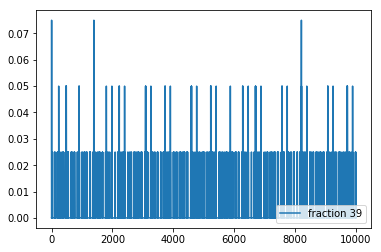

In [47]:
fractions = np.zeros(intT)

for t in range(intT):
    times[t] = t *dt
    fraction = 0
    for i in range(N):
        if v_t_fire[i, t] == 1:
            fraction +=1
    fraction = fraction / N
    #print(fraction)
    fractions[t] = fraction

plt.plot(times, fractions, label='fraction {}'.format(i))

plt.legend(loc="lower right")

In [29]:
I_b

array([14.43671875, 14.92582391, 15.02700051, 14.80572053, 14.70109422,
       14.3893962 , 14.60935281, 14.93683345, 14.43165573, 14.79594973,
       14.57062148, 14.46877587, 14.81609787, 15.03896724, 14.69610399,
       14.32126835, 14.84130123, 14.95774344, 14.75087525, 14.74037668,
       15.02020772, 14.43828318, 14.57008934, 14.70581344, 14.3623441 ,
       14.58076894, 14.77067809, 14.95289666, 14.32318641, 14.93902826,
       15.0726291 , 14.80396155, 14.47715664, 14.45296123, 14.90283277,
       14.35049177, 14.72954361, 14.52412826, 14.58487084, 14.66843575])

In [28]:
for i in range(40):
    print("{} Jij[{}]".format(J_ij[i, :], i))

[0.        0.        0.        0.        7.6117347 0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.       ] Jij[0]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         5.30959941 0.
 0.         1.72443614 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] Jij[1]
[ 0.          0.          0.          8.56128829  0.          0.
  0.          0.          0.          0.          0.          7.5475891
  0.          0.          0.          0.          0.          0.
  0.        

In [86]:
t_rec

array([ 859.16418871,  581.43987184, 1008.68716396,  924.77790116,
        818.08419372,  736.57548613,  417.94754521,  795.17940596,
        879.98714463,  786.57893119,  858.85055073,  870.50849352,
        906.87498545,  761.22556325,  969.76742197,  659.90735554,
        607.66824891,  826.23465774,  713.74753225,  576.46324488,
        975.13869507,  760.77750781,  927.368518  ,  459.75420274,
        998.36759139,  718.21203755,  699.93173391,  968.17039529,
        903.17815255, 1061.82507858, 1013.51847815,  599.70890625,
        553.13322927,  571.02174215,  792.4143201 ,  969.21931441,
        940.7427936 ,  829.79121637,  581.79679914,  623.00394134])

In [87]:
theta_i_t[0, :100]

array([15.        , 15.        , 15.        , 15.        , 15.        ,
       15.        , 15.        , 15.        , 15.        , 15.        ,
       15.        , 15.        , 15.        , 15.05956569, 15.05950613,
       15.05944662, 15.05938717, 15.05932779, 15.05926846, 15.05920919,
       15.05914998, 15.05909083, 15.05903174, 15.05897271, 15.05891374,
       15.05885482, 15.05879597, 15.05873717, 15.05867843, 15.05861976,
       15.05856114, 15.05850257, 15.05844407, 15.05838563, 15.05832724,
       15.05826892, 15.05821065, 15.05815244, 15.05809428, 15.05803619,
       15.05797815, 15.05792017, 15.05786225, 15.05780439, 15.05774659,
       15.05768884, 15.05763115, 15.05757352, 15.05751595, 15.05745843,
       15.05740097, 15.05734357, 15.05728623, 15.05722894, 15.05717171,
       15.05711454, 15.05705743, 15.05700037, 15.05694337, 15.05688643,
       15.05682954, 15.05677271, 15.05671594, 15.05665922, 15.05660256,
       15.05654596, 15.05648941, 15.05643292, 15.05637649, 15.05

In [88]:
S_i

array([ 0.05956569, -0.07046547,  0.0511083 ,  0.03293979, -0.0714684 ,
       -0.07661025,  0.04722783,  0.04723782,  0.01096039,  0.04834779,
        0.00716874, -0.00738126, -0.0242722 , -0.05688181, -0.02172693,
       -0.00218162, -0.07845069,  0.05474774,  0.03384602, -0.02524183,
       -0.0422021 ,  0.01476412, -0.02097794, -0.01984721, -0.03357607,
        0.00266914, -0.07811224, -0.02999732,  0.0245163 ,  0.04499167,
       -0.08458261,  0.04032898,  0.00736851, -0.07619355, -0.0854338 ,
       -0.07752315, -0.06694093,  0.00018516,  0.03945499, -0.00830724])